# Multi-Class Classification Model for Human Activities and Postural Transitions Using Python Take 1
### David Lowe
### January 28, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Human Activities and Postural Transitions dataset is a classic multi-class classification situation where we are trying to predict one of the 12 possible outcomes.

INTRODUCTION: The research team carried out experiments with a group of 30 volunteers who performed a protocol of activities composed of six basic activities. There are three static postures (standing, sitting, lying) and three dynamic activities (walking, walking downstairs and walking upstairs). The experiment also included postural transitions that occurred between the static postures. These are stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand. All the participants were wearing a smartphone on the waist during the experiment execution. The research team also video-recorded the activities to label the data manually. The research team randomly partitioned the obtained data into two sets, 70% for the training data and 30% for the testing.

In the current iteration Take1, the script will focus on evaluating various machine learning algorithms and identifying the model that produces the best overall metrics. Iteration Take1 will establish the baseline performance for accuracy and processing time.

ANALYSIS: In the current iteration Take1, the baseline performance of the machine learning algorithms achieved an average accuracy of 88.52%. Two algorithms (Linear Discriminant Analysis and Stochastic Gradient Boosting) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Linear Discriminant Analysis turned in the top overall result and achieved an accuracy metric of 94.19%. By using the optimized parameters, the Linear Discriminant Analysis algorithm processed the testing dataset with an accuracy of 94.71%, which was even better than the training data.

From the model-building perspective, the number of attributes decreased by 108, from 561 down to 453.

CONCLUSION: For this iteration, the Linear Discriminant Analysis algorithm achieved the best overall results. For this dataset, we should consider using the Linear Discriminant Analysis algorithm for further modeling or production use.

Dataset Used: Smartphone-Based Recognition of Human Activities and Postural Transitions Data Set

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [43]:
import math
import numpy as np
import pandas as pd
import smtplib
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [44]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [45]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [46]:
startTimeScript = datetime.now()

widthVector = [16] * 561
colNames = ["attr" + str(i) for i in range(1,562)]
x_train_df = pd.read_csv('X_train.txt', sep=' ', names=colNames)
y_train_df = pd.read_csv('Y_train.txt', names=["targetVar"])
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
x_test_df = pd.read_csv('X_test.txt', sep=' ', names=colNames)
y_test_df = pd.read_csv('Y_test.txt', names=["targetVar"])

In [47]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_train_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [48]:
print("xy_train_df.shape: {}".format(xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_train_df.shape: (7767, 562)
x_train_df.shape: (7767, 561) y_train_df.shape: (7767, 1)
x_test_df.shape: (3162, 561) y_test_df.shape: (3162, 1)


### 1.d) Set up the key parameters to be used in the script

In [49]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [50]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [51]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [52]:
xy_train_df.head(10)

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr553,attr554,attr555,attr556,attr557,attr558,attr559,attr560,attr561,targetVar
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,5
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,5
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,5
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,5
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,5
5,0.038988,0.004109,-0.017340,-0.997438,-0.993485,-0.996692,-0.997522,-0.993494,-0.996916,-0.801982,...,-0.554902,-0.844224,0.082632,-0.143439,0.275041,-0.368224,-0.849927,0.184795,-0.035326,5
6,0.039897,-0.005324,-0.020457,-0.997024,-0.977313,-0.987782,-0.996898,-0.977450,-0.989391,-0.800606,...,-0.235576,-0.571126,-0.212754,-0.230622,0.014637,-0.189512,-0.852441,0.182142,-0.036203,5
7,0.039082,-0.016047,-0.030241,-0.996662,-0.976996,-0.986672,-0.996380,-0.977594,-0.989310,-0.800606,...,-0.104337,-0.432022,-0.020888,0.593996,-0.561871,0.467383,-0.851309,0.183751,-0.035176,5
8,0.039026,-0.007410,-0.027301,-0.997431,-0.973190,-0.988183,-0.997491,-0.971557,-0.990156,-0.800245,...,-0.286366,-0.579474,0.012954,0.080936,-0.234313,0.117797,-0.848270,0.188955,-0.030594,5
9,0.040354,0.004245,-0.017932,-0.994906,-0.981181,-0.990046,-0.995300,-0.982483,-0.990920,-0.799717,...,0.306076,0.115919,-0.020590,-0.127730,-0.482871,-0.070670,-0.848592,0.190283,-0.027667,5


#### 2.a.ii) Dimensions of the dataset.

In [53]:
xy_train_df.shape

(7767, 562)

#### 2.a.iii) Types of the attributes.

In [54]:
xy_train_df.dtypes

attr1        float64
attr2        float64
attr3        float64
attr4        float64
attr5        float64
attr6        float64
attr7        float64
attr8        float64
attr9        float64
attr10       float64
attr11       float64
attr12       float64
attr13       float64
attr14       float64
attr15       float64
attr16       float64
attr17       float64
attr18       float64
attr19       float64
attr20       float64
attr21       float64
attr22       float64
attr23       float64
attr24       float64
attr25       float64
attr26       float64
attr27       float64
attr28       float64
attr29       float64
attr30       float64
              ...   
attr533      float64
attr534      float64
attr535      float64
attr536      float64
attr537      float64
attr538      float64
attr539      float64
attr540      float64
attr541      float64
attr542      float64
attr543      float64
attr544      float64
attr545      float64
attr546      float64
attr547      float64
attr548      float64
attr549      

#### 2.a.iv) Statistical summary of all attributes.

In [55]:
xy_train_df.describe()

,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,...,attr553,attr554,attr555,attr556,attr557,attr558,attr559,attr560,attr561,targetVar
count,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,...,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000,7767.000000
mean,0.038759,-0.000647,-0.018155,-0.599017,-0.634424,-0.691270,-0.623886,-0.657884,-0.740154,-0.360200,...,-0.316548,-0.625132,0.016774,0.018471,0.009239,-0.005184,-0.485936,0.050310,-0.052888,3.934595
std,0.101996,0.099974,0.089927,0.441481,0.367558,0.321641,0.418113,0.348005,0.272619,0.499259,...,0.313899,0.302581,0.331326,0.443540,0.601208,0.477218,0.509278,0.300866,0.276196,2.160171
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.987874,1.000000
25%,0.032037,-0.011209,-0.028448,-0.992140,-0.983570,-0.984661,-0.992902,-0.984131,-0.986661,-0.795613,...,-0.548129,-0.843966,-0.108225,-0.261002,-0.470267,-0.373565,-0.810953,-0.047752,-0.140560,2.000000
50%,0.038975,-0.002921,-0.019602,-0.914202,-0.827970,-0.827696,-0.924421,-0.838559,-0.852735,-0.717007,...,-0.353980,-0.710071,0.017627,0.029079,0.001515,-0.005503,-0.706619,0.176777,0.004583,4.000000
75%,0.044000,0.004303,-0.011676,-0.246026,-0.313069,-0.450478,-0.294903,-0.362671,-0.540521,0.054178,...,-0.137462,-0.503837,0.167695,0.314876,0.496871,0.352690,-0.488765,0.246834,0.109507,5.000000
max,1.000000,1.000000,1.000000,1.000000,0.945956,1.000000,1.000000,0.960341,1.000000,1.000000,...,0.938491,0.911653,1.000000,1.000000,0.998702,0.991288,1.000000,0.482229,1.000000,12.000000


#### 2.a.v) Count missing values.

In [56]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 attr1        0
attr2        0
attr3        0
attr4        0
attr5        0
attr6        0
attr7        0
attr8        0
attr9        0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
            ..
attr533      0
attr534      0
attr535      0
attr536      0
attr537      0
attr538      0
attr539      0
attr540      0
attr541      0
attr542      0
attr543      0
attr544      0
attr545      0
attr546      0
attr547      0
attr548      0
attr549      0
attr550      0
attr551      0
attr552      0
attr553      0
attr554      0
attr555      0
attr556      0
attr557      0
attr558      0
attr559      0
attr560      0
attr561      0
targetVar    0
Length: 562, dtype: int64
Total number of Na

#### 2.a.vi) Summarize the levels of the class attribute.

In [57]:
xy_train_df.groupby('targetVar').size()

targetVar
1     1226
2     1073
3      987
4     1293
5     1423
6     1413
7       47
8       23
9       75
10      60
11      90
12      57
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

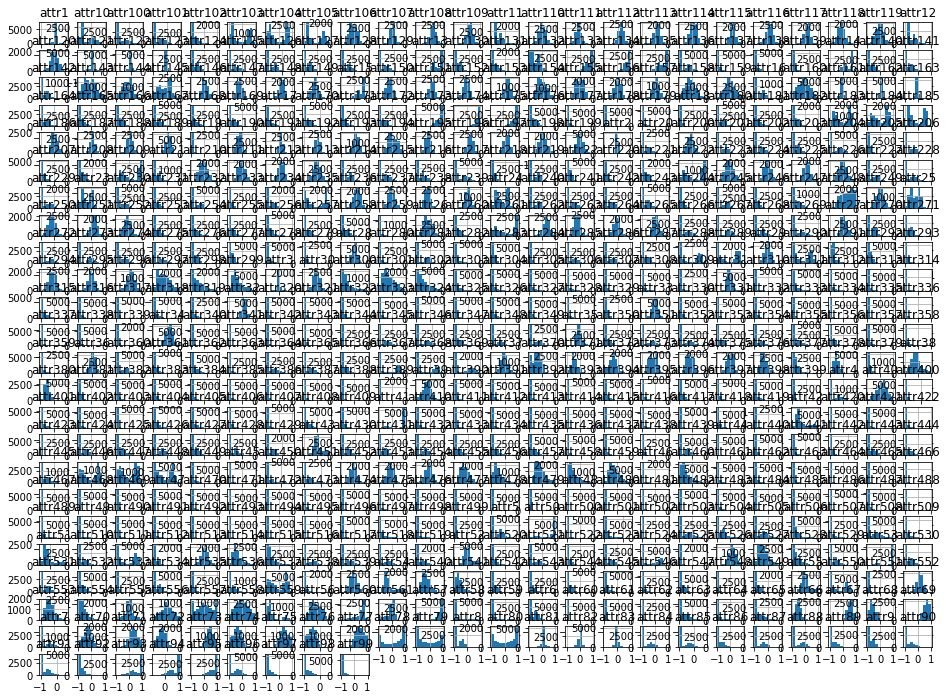

In [58]:
# Histograms for each attribute
x_train_df.hist()
pyplot.show()

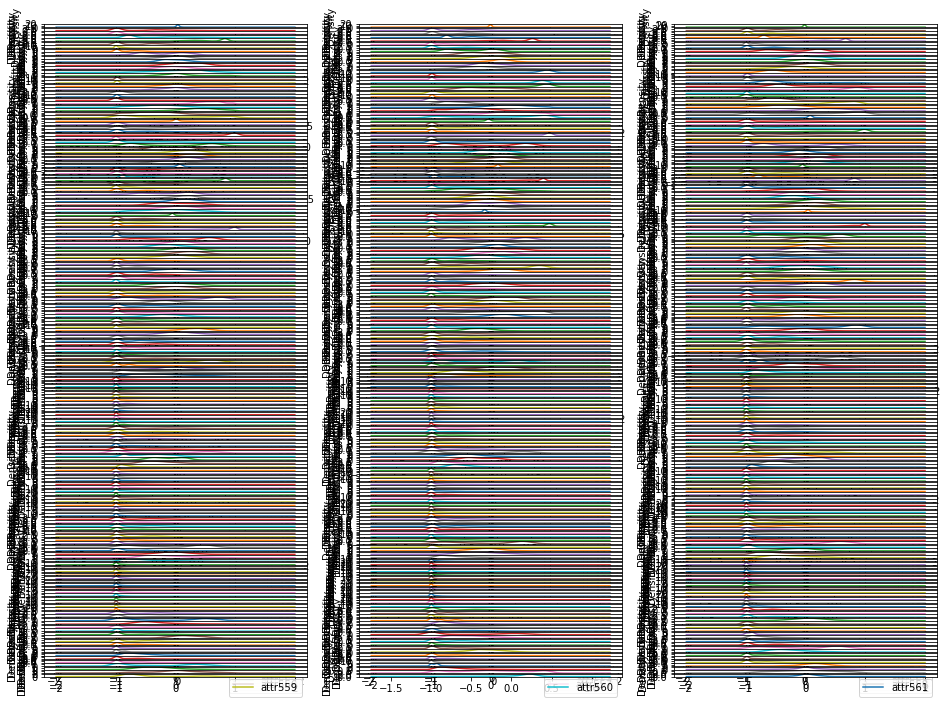

In [59]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

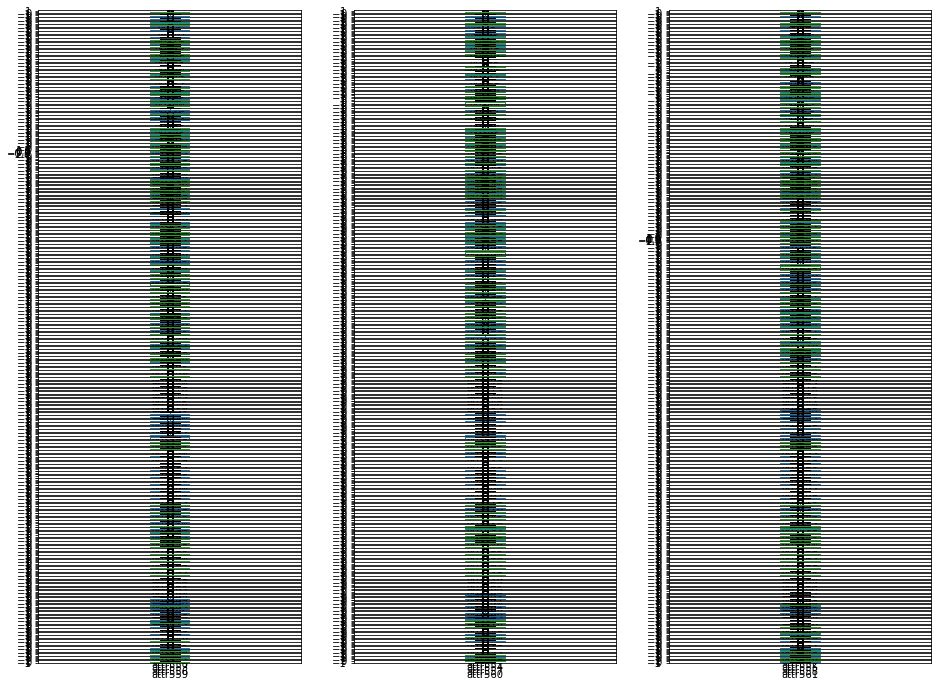

In [60]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [61]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

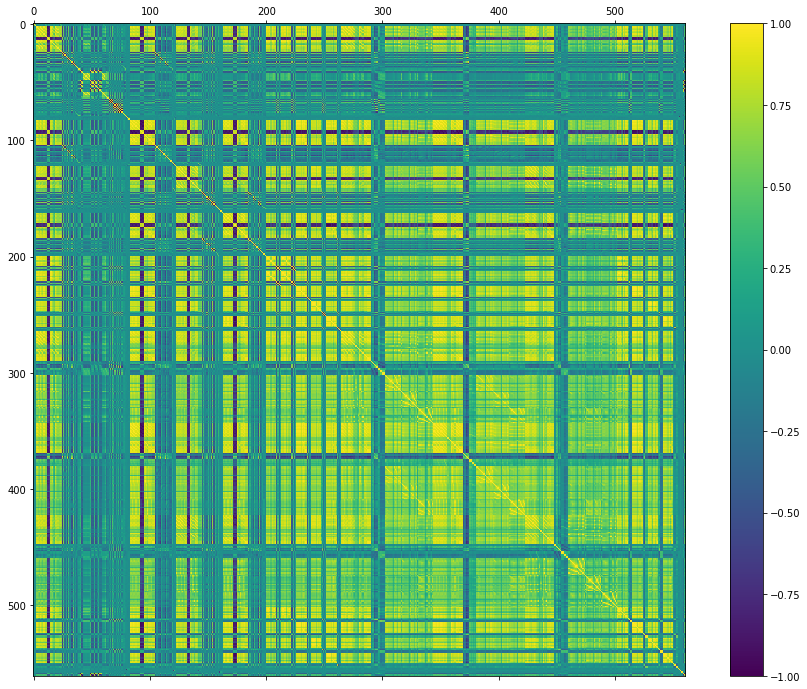

In [62]:
# Correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [63]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [64]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [65]:
# Not applicable for this iteration of the project.

### 3.b) Feature Selection

In [66]:
def findCorrelated(corrmat, cutoff = 0.85):    

### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# args:
    # corrmat: a correlation matrix
    # cutoff: pairwise absolute correlation cutoff
# returns:
    # variables to removed

    if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
    averageCorr = corrmat.abs().mean(axis = 1)

    # set lower triangle and diagonal of correlation matrix to NA
    for row in range(0, len(corrmat)):
        for col in range(0, (row+1)):
            corrmat.iloc[row, col] = None

    # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
    to_delete = list()
    for col in range(0, len(corrmat.columns)):
        for row in range(0, len(corrmat)):
            if(abs(corrmat.iloc[row, col]) > cutoff):
                if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
                else: to_delete.append(col)

    to_delete = list(set(to_delete))
    return to_delete

In [67]:
# By using the calculated correlation matrix, find the collinear features
collinear = findCorrelated(correlations, cutoff = 0.99)
print('Number of attributes to be removed:', len(collinear))
dropAttributes = x_train_df.columns[collinear]
print('Columns to be removed:')
print(dropAttributes)

Number of attributes to be removed: 108
Columns to be removed:
Index(['attr4', 'attr5', 'attr6', 'attr7', 'attr8', 'attr9', 'attr516',
       'attr518', 'attr521', 'attr524',
       ...
       'attr412', 'attr416', 'attr430', 'attr440', 'attr441', 'attr442',
       'attr473', 'attr488', 'attr501', 'attr508'],
      dtype='object', length=108)


In [68]:
# Drop the highly collinear features
x_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
x_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

### 3.c) Data Transforms

In [69]:
# Not applicable for this iteration of the project.

### 3.d) Display the Final Datasets for Model-Building

In [70]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values.ravel()
x_test = x_test_df.values
y_test = y_test_df.values.ravel()
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (7767, 453) y_train.shape: (7767,)
x_test.shape: (3162, 453) y_test.shape: (3162,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, and Stochastic Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [71]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [72]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('BDT', BaggingClassifier(random_state=seedNum)))
models.append(('RF', RandomForestClassifier(random_state=seedNum)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
results = []
names = []
metrics = []

In [73]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

LDA: 0.941942 (0.035711)
Model training time: 0:00:07.116481
CART: 0.822083 (0.037432)
Model training time: 0:00:36.082524
KNN: 0.878470 (0.041052)
Model training time: 0:00:31.285508
BDT: 0.870881 (0.047047)
Model training time: 0:03:38.735384


C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-package

RF: 0.885165 (0.031615)
Model training time: 0:00:10.817391


C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user_hhds7y1\Anaconda3\lib\site-package

ET: 0.884523 (0.033577)
Model training time: 0:00:02.755448
GBM: 0.913485 (0.044762)
Model training time: 0:49:54.288982
Average metrics (accuracy) from all models: 0.8852214248753276


### 4.b) Spot-checking baseline algorithms

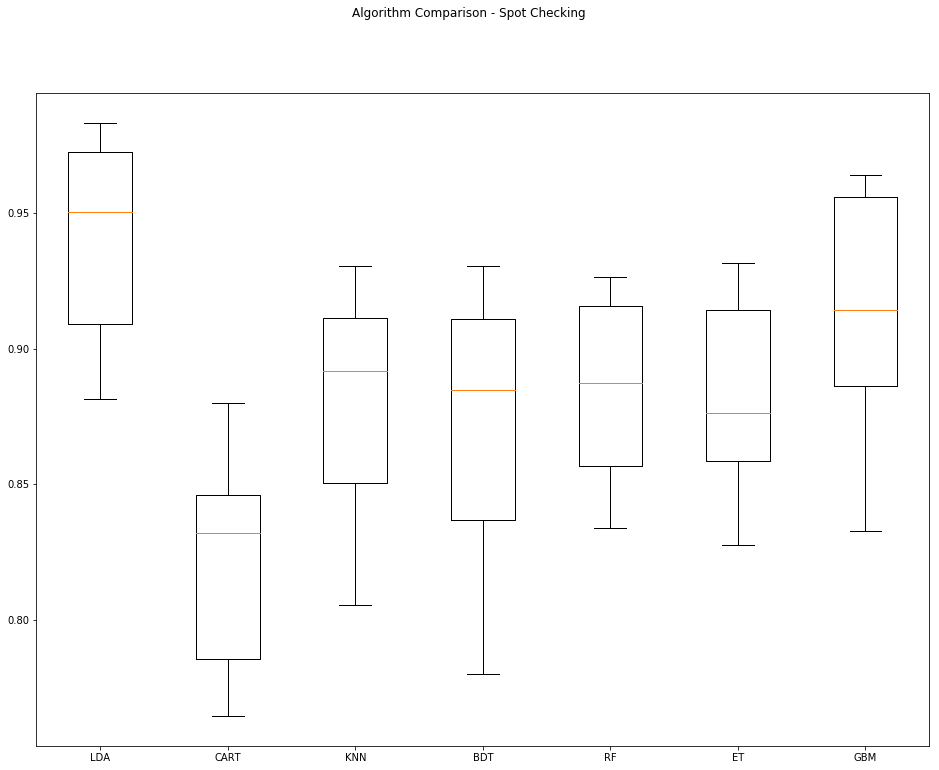

In [74]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [75]:
# Set up the comparison array
results = []
names = []

In [76]:
# Tuning algorithm #1 - Linear Discriminant Analysis
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict()
model1 = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('LDA')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Best: 0.941934 using {}
0.941934 (0.035713) with: {}
Model training time: 0:00:08.181931


In [77]:
# Tuning algorithm #2 - Stochastic Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([300,400,500,600]))
model2 = GradientBoostingClassifier(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.920046 using {'n_estimators': 500}
0.918501 (0.043067) with: {'n_estimators': 300}
0.919660 (0.043257) with: {'n_estimators': 400}
0.920046 (0.043255) with: {'n_estimators': 500}
0.920046 (0.043255) with: {'n_estimators': 600}
Model training time: 6:00:23.022469


### 5.b) Compare Algorithms After Tuning

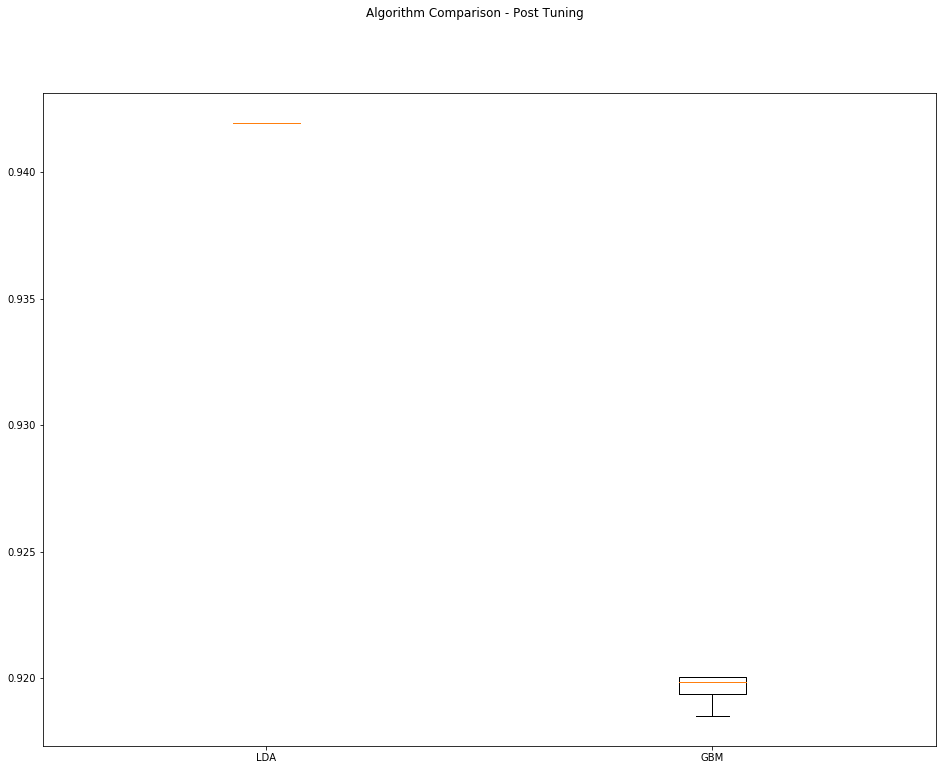

In [78]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [79]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [80]:
model = LinearDiscriminantAnalysis()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9471853257432005
[[487   8   1   0   0   0   0   0   0   0   0   0]
 [ 11 460   0   0   0   0   0   0   0   0   0   0]
 [  1  17 402   0   0   0   0   0   0   0   0   0]
 [  0   0   0 446  60   0   2   0   0   0   0   0]
 [  0   0   0  21 535   0   0   0   0   0   0   0]
 [  0   0   0   0   0 545   0   0   0   0   0   0]
 [  0   0   0   1   0   0  22   0   0   0   0   0]
 [  0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0  24   0   8   0]
 [  0   0   0   0   0   0   1   0   0  14   0  10]
 [  1   0   0   2   0   1   5   0  10   0  30   0]
 [  0   0   0   0   0   0   1   0   0   5   1  20]]
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       496
           2       0.95      0.98      0.96       471
           3       1.00      0.96      0.98       420
           4       0.95      0.88      0.91       508
           5       0.90      0.96      0.93       556
           6       1.00      1.00      1.00

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### 6.b) Create standalone model on entire training dataset

In [81]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = LinearDiscriminantAnalysis()
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (10929, 453) y_complete.shape: (10929,)
Model training time: 0:00:01.108416


C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### 6.c) Save model for later use

In [82]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [83]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 7:03:12.246204
